In [7]:
import tensorflow_datasets as tfds
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\daars\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
## MNIST dataset

mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
print(datasets.keys())
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']

dict_keys(['train', 'test'])


In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20

In [11]:
mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

In [12]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))
    
model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

In [13]:
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 7, 7, 64])

In [14]:
model.add(tf.keras.layers.Flatten())
    
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 3136])

In [15]:
model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))
    
model.add(tf.keras.layers.Dense(
    units=10, name='fc_2',
    activation='softmax'))

In [16]:
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))

model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 10])

In [17]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 pool_1 (MaxPooling2D)       (None, 14, 14, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 14, 14, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 fc_1 (Dense)                (None, 1024)              3212288   
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`

history = model.fit(mnist_train, epochs=NUM_EPOCHS, 
                    validation_data=mnist_valid, 
                    shuffle=True)

Epoch 1/20
782/782 [==============================] - 101s 125ms/step - loss: 0.1374 - accuracy: 0.9572 - val_loss: 0.0479 - val_accuracy: 0.9848
Epoch 2/20
782/782 [==============================] - 101s 128ms/step - loss: 0.0452 - accuracy: 0.9858 - val_loss: 0.0424 - val_accuracy: 0.9880
Epoch 3/20
782/782 [==============================] - 101s 128ms/step - loss: 0.0297 - accuracy: 0.9906 - val_loss: 0.0408 - val_accuracy: 0.9882
Epoch 4/20
782/782 [==============================] - 100s 128ms/step - loss: 0.0223 - accuracy: 0.9930 - val_loss: 0.0381 - val_accuracy: 0.9888
Epoch 5/20
782/782 [==============================] - 104s 133ms/step - loss: 0.0183 - accuracy: 0.9942 - val_loss: 0.0409 - val_accuracy: 0.9884
Epoch 6/20
782/782 [==============================] - 104s 132ms/step - loss: 0.0150 - accuracy: 0.9953 - val_loss: 0.0380 - val_accuracy: 0.9908
Epoch 7/20
782/782 [==============================] - 104s 133ms/step - loss: 0.0118 - accuracy: 0.9964 - val_loss: 0.0499 -

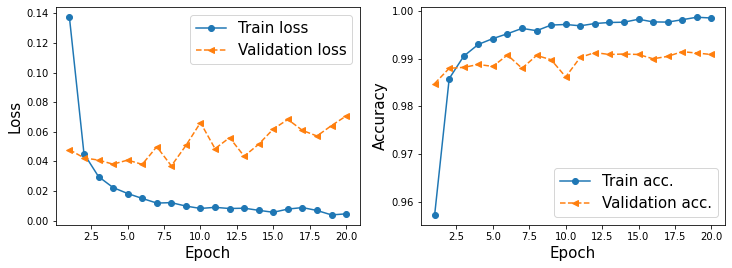

In [20]:
import numpy as np 
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/15_12.png', dpi=300)
plt.show()

In [21]:
test_results = model.evaluate(mnist_test.batch(20))
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

500/500 [==============================] - 7s 14ms/step - loss: 0.0503 - accuracy: 0.9924

Test Acc. 99.24%


TensorShape([12, 10])
tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


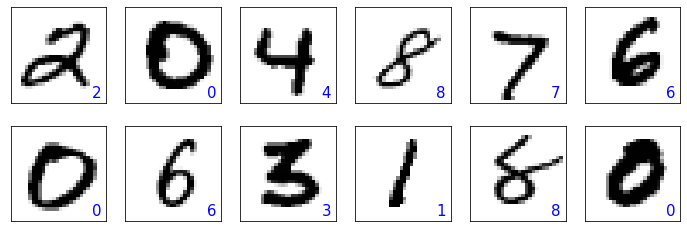

In [22]:
batch_test = next(iter(mnist_test.batch(12)))

preds = model(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('figures/15_13.png', dpi=300)
plt.show()